# Running an MSTIS simulation

Now we will use the initial trajectories we obtained from bootstrapping to run an MSTIS simulation. This will show both how objects can be regenerated from storage and how regenerated equivalent objects can be used in place of objects that weren't stored.

Tasks covered in this notebook:
* Loading OPS objects from storage
* Ways of assigning initial trajectories to initial samples
* Setting up a path sampling simulation with various move schemes
* Visualizing trajectories while the path sampling is running

In [1]:
%matplotlib inline
import openpathsampling as paths
import numpy as np

### Loading things from storage

First we'll reload some of the stuff we stored before. Of course, this starts with opening the file.

In [2]:
old_store = paths.AnalysisStorage("mstis_bootstrap.nc")

A lot of information can be recovered from the old storage, and so we don't have the recreate it. However, we did not save our network, so we'll have to create a new one. Since the network creates the ensembles, that means we will have to translate the trajectories from the old ensembles to new ensembles.

In [3]:
print "PathMovers:", len(old_store.pathmovers)
print "Samples:", len(old_store.samples)
print "Ensembles:", len(old_store.ensembles)
print "SampleSets:", len(old_store.samplesets)
print "Snapshots:", len(old_store.snapshots)
print "Networks:", len(old_store.networks)

PathMovers: 0
Samples: 10
Ensembles: 100
SampleSets: 1
Snapshots: 1210
Networks: 0


Loading from storage is very easy. Each store is a list. We take the 0th snapshot as a template (it doesn't actually matter which one) for the next storage we'll create. There's only one engine stored, so we take the only one.

In [4]:
template = old_store.snapshots[0]

In [5]:
engine = old_store.engines[0]

Named objects can be found in storage by using their name as a dictionary key. This allows us to load our old collective variables and states.

In [6]:
opA = old_store.cvs['opA']
opB = old_store.cvs['opB']
opC = old_store.cvs['opC']

In [7]:
stateA = old_store.volumes['A']
stateB = old_store.volumes['B']
stateC = old_store.volumes['C']

In [8]:
# we could also load the interfaces, but it takes less code to build new ones:
interfacesA = paths.VolumeInterfaceSet(opA, 0.0,[0.2, 0.3, 0.4])
interfacesB = paths.VolumeInterfaceSet(opB, 0.0,[0.2, 0.3, 0.4])
interfacesC = paths.VolumeInterfaceSet(opC, 0.0,[0.2, 0.3, 0.4])

Once again, we have everything we need to build the MSTIS network. Recall that this will create all the ensembles we need for the simulation. However, even though the ensembles are semantically the same, these are not the same objects. We'll need to deal with that later.

In [9]:
ms_outers = paths.MSOuterTISInterface.from_lambdas(
    {ifaces: 0.5 
     for ifaces in [interfacesA, interfacesB, interfacesC]}
)
mstis = paths.MSTISNetwork(
    [(stateA, interfacesA),
     (stateB, interfacesB),
     (stateC, interfacesC)],
    ms_outers=ms_outers
)

Now we need to set up real trajectories that we can use for each of these. We can start by loading the stored sampleset.

In [10]:
# load the sampleset we have saved before
old_sampleset = old_store.samplesets[0]

#### About `Sample`s

The OPS object called `Sample` is used to associate a trajectory with a replica ID and an ensemble. The trajectory needs to be associated with an ensemble so we know how to get correct statistics from the many ensembles that we might be sampling simultaneously. The trajectory needs to be associated with a replica ID so that replica exchange approaches can be analyzed.



Since the ensembles in our MSTIS network are not the exact ensemble objects that we saved our samples with (they were rebuilt), we still need a way to identify which of the new ensembles to associate them with.

There are two main ways to do this. The first is to take one trajectory, and associate it with as many ensembles as possible. If your first path comes from a TPS simulation, that is the approach you'll want to take.

The second approach is better suited to our conditions here: we already have a good trajectory for each ensemble. So we just want to remap our old ensembles to new ones.

### Loading one trajectory into lots of ensembles

In [11]:
# this makes a dictionary mapping the outermost ensemble of each sampling transition 
# to a trajectory from the old_sampleset that satisfies that ensemble
trajs = {}
for ens in [t.ensembles[-1] for t in mstis.sampling_transitions]:
    trajs[ens] = [s.trajectory for s in old_sampleset if ens(s.trajectory)][0]
    
assert(len(trajs)==3) # otherwise, we have a problem

(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x10869aa90>, 119821506910823800303319164102417322217L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x10869ae10>, 119821506910823800303319164102417322201L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179687d0>, 119821506910823800303319164102417326516L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x117968590>, 119821506910823800303319164102417326534L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179685d0>, 119821506910823800303319164102417326552L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x117968f50>, 119821506910823800303319164102417326570L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<op

(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x117971b50>, 119821506910823800303319164102417371966L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x117971c50>, 119821506910823800303319164102417371984L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x117971750>, 119821506910823800303319164102417372002L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x117971190>, 119821506910823800303319164102417372020L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x117971c10>, 119821506910823800303319164102417372038L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x117971310>, 119821506910823800303319164102417372056L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<op

(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179854d0>, 119821506910823800303319164102417373028L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179859d0>, 119821506910823800303319164102417373046L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x117985a90>, 119821506910823800303319164102417373064L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x117985210>, 119821506910823800303319164102417373082L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x117985fd0>, 119821506910823800303319164102417373100L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x117985b90>, 119821506910823800303319164102417373118L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<op

(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179a3910>, 119821506910823800303319164102417499779L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179a3950>, 119821506910823800303319164102417499763L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179a3a90>, 119821506910823800303319164102417499747L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179a3990>, 119821506910823800303319164102417499731L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179a39d0>, 119821506910823800303319164102417499715L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179a3a10>, 119821506910823800303319164102417499699L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<op

(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179b5690>, 119821506910823800303319164102417498931L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179b56d0>, 119821506910823800303319164102417498915L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179b5710>, 119821506910823800303319164102417498899L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179b5750>, 119821506910823800303319164102417498883L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179b5790>, 119821506910823800303319164102417498867L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179b57d0>, 119821506910823800303319164102417498851L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<op

(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179ca450>, 119821506910823800303319164102417498051L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179ca4d0>, 119821506910823800303319164102417498035L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179ca550>, 119821506910823800303319164102417498019L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179ca590>, 119821506910823800303319164102417498003L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179ca5d0>, 119821506910823800303319164102417497987L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179ca610>, 119821506910823800303319164102417497971L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<op

(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179da410>, 119821506910823800303319164102417492304L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179da310>, 119821506910823800303319164102417492322L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179da350>, 119821506910823800303319164102417492340L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179da390>, 119821506910823800303319164102417492358L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179da3d0>, 119821506910823800303319164102417492376L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179da450>, 119821506910823800303319164102417492394L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<op

(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179ed0d0>, 119821506910823800303319164102417643435L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179ed110>, 119821506910823800303319164102417643419L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179ed150>, 119821506910823800303319164102417643403L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179ed190>, 119821506910823800303319164102417643387L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179ed1d0>, 119821506910823800303319164102417637357L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179ed210>, 119821506910823800303319164102417637341L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<op

(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179edd90>, 119821506910823800303319164102417647054L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179eddd0>, 119821506910823800303319164102417647072L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179ede10>, 119821506910823800303319164102417647090L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179ede50>, 119821506910823800303319164102417647108L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179ede90>, 119821506910823800303319164102417647126L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179eded0>, 119821506910823800303319164102417647144L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<op

(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179ffcd0>, 119821506910823800303319164102417775608L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179ffd10>, 119821506910823800303319164102417775626L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179ffd50>, 119821506910823800303319164102417775644L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179ffd90>, 119821506910823800303319164102417775662L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179ffdd0>, 119821506910823800303319164102417775680L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x1179ffe10>, 119821506910823800303319164102417775698L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<op

(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x117a12a10>, 119821506910823800303319164102417801594L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x117a12a50>, 119821506910823800303319164102417801612L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x117a12a90>, 119821506910823800303319164102417801630L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x117a12ad0>, 119821506910823800303319164102417801648L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x117a129d0>, 119821506910823800303319164102417801666L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x117a12b10>, 119821506910823800303319164102417801684L, store.snapshots[BaseSnapshot] : 1210 object(s))
(<op

In [12]:
initial_samples = {}
for t in mstis.sampling_transitions:
    initial_samples[t] = paths.SampleSet.map_trajectory_to_ensembles(trajs[t.ensembles[-1]], t.ensembles)

In [13]:
single_trajectory_sset = paths.SampleSet.relabel_replicas_per_ensemble(initial_samples.values())

The `sanity_check` function ensures that all trajectories in the sampleset are actually in the ensemble they claim to be associated with. At this point, we should have 9 samples.

In [14]:
single_trajectory_sset.sanity_check()
assert(len(single_trajectory_sset)==9)

### Remapping old ensembles to new ensembles

If your old and new ensembles have the same string representations, then OPS has a function to help you automatically map them. As long as you create the ensembles in the same way, they'll have the same string representation. Note that if you *don't* have the same string representation, you would have to assign trajectories to ensembles by hand (which isn't that hard, but is a bit tedious).

In [15]:
sset = paths.SampleSet.translate_ensembles(old_sampleset, mstis.sampling_ensembles)

In [16]:
sset.sanity_check()
assert(len(sset)==9)

In [17]:
# tests only: this cell sets something for the online testing
# the next cell unsets it when running the notebook live
bootstrap_sset = sset
sset = single_trajectory_sset

In [18]:
#! skip
# tests don't run this, but users should!
sset = bootstrap_sset

### Setting up special ensembles

Whichever way we initially set up the `SampleSet`, at this point it only contains samples for the main sampling trajectories of each transition. Now we need to put trajectories into various auxiliary ensembles.

#### Multiple state outer ensemble

The multiple state outer ensemble is, in fact, sampled during the bootstrapping. However, it is actually sampled once for every state that shares it. It is very easy to find a trajectory that satisfies the ensemble and to load add that sample to our sampleset.

In [19]:
for outer_ens in mstis.special_ensembles['ms_outer']:
    # doesn't matter which we take, so we take the first
    traj = next(s.trajectory for s in old_sampleset if outer_ens(s.trajectory)==True)
    samp = paths.Sample(
            replica=None,
            ensemble=outer_ens,
            trajectory=traj
    )
    # now we apply it and correct for the replica ID
    sset.append_as_new_replica(samp)

In [20]:
sset.sanity_check()
assert(len(sset)==10)

#### Minus interface ensemble

The minus interface ensembles do not yet have a trajectory. We will generate them by starting with same-state trajectories (A-to-A, B-to-B, C-to-C) in each interface, and extending into the minus ensemble.

* check whether the traj is A-to-A
* extend

First we need to make sure that the trajectory in the innermost ensemble of each state also ends in that state. This is necessary so that when we extend the trajectory, it can extends into the minus ensemble.

If the trajectory isn't right, we run a shooting move on it until it is.

In [21]:
for transition in mstis.sampling_transitions:
    innermost_ensemble = transition.ensembles[0]
    shooter = None
    if not transition.stateA(sset[innermost_ensemble].trajectory[-1]):
        shooter = paths.OneWayShootingMover(ensemble=innermost_ensemble,
                                            selector=paths.UniformSelector(),
                                            engine=engine)
        pseudoscheme = paths.LockedMoveScheme(root_mover=shooter)
        pseudosim = paths.PathSampling(storage=None, 
                                       move_scheme=pseudoscheme, 
                                       sample_set=sset,
                                      )
    while not transition.stateA(sset[innermost_ensemble].trajectory[-1]):
        pseudosim.run(1)
        sset = pseudosim.sample_set

    

Now that all the innermost ensembles are safe to use for extending into a minus interface, we extend them into a minus interface:

In [22]:
minus_samples = []
for transition in mstis.sampling_transitions:
    minus_samples.append(transition.minus_ensemble.extend_sample_from_trajectories(
        sset[transition.ensembles[0]].trajectory,
        replica=-len(minus_samples)-1,
        engine=engine
    ))
sset = sset.apply_samples(minus_samples)

In [23]:
sset.sanity_check()
assert(len(sset)==13)

## Equilibration

In molecular dynamics, you need to equilibrate if you don't start with an equilibrium frame (e.g., if you start with solvent molecules on a grid, your system should equilibrate before you start taking statistics). Similarly, if you start with a set of paths which are far from the path ensemble equilibrium, you need to equilibrate. This could either be because your trajectories are not from the real dynamics (generated with metadynamics, high temperature, etc.) or because your trajectories are not representative of the path ensemble (e.g., if you put transition trajectories into all interfaces).

As with MD, running equilibration can be the same process as running the total simulation. However, in path sampling, it doesn't have to be: we can equilibrate without replica exchange moves or path reversal moves, for example. In the example below, we create a `MoveScheme` that only includes shooting movers.

In [24]:
equil_scheme = paths.OneWayShootingMoveScheme(mstis, engine=engine)

In [25]:
equilibration = paths.PathSampling(
    storage=None,
    sample_set=sset,
    move_scheme=equil_scheme
)

In [26]:
#! skip
# tests need the unequilibrated samples to ensure passing
equilibration.run(5)

Working on Monte Carlo cycle number 5
Running for 0 seconds -  0.21 seconds per step
Estimated time remaining: 0 seconds
DONE! Completed 5 Monte Carlo cycles.


In [27]:
sset = equilibration.sample_set

## Running RETIS

Now we run the full calculation. Up to here, we haven't been storing any of our results. This time, we'll start a storage object, and we'll save the network we've created. Then we'll run a new `PathSampling` calculation object.

In [28]:
# logging creates ops_output.log file with details of what the calculation is doing
#import logging.config
#logging.config.fileConfig("../resources/logging.conf", disable_existing_loggers=False)

In [29]:
storage = paths.storage.Storage("mstis.nc", "w")

In [30]:
storage.save(template)

(store.snapshots[BaseSnapshot] : 2 object(s),
 2,
 119821506910823800303319164102417322217L)

In [31]:
[cv.with_diskcache() for cv in old_store.cvs]

In [32]:
print [cv.diskcache_allow_incomplete for cv in old_store.cvs]

[False, False, False]


In [33]:
mstis_calc = paths.PathSampling(
    storage=storage,
    sample_set=sset,
    move_scheme=paths.DefaultScheme(mstis, engine=engine)
)
mstis_calc.save_frequency = 50

The next block sets up a live visualization. This is optional, and only recommended if you're using OPS interactively (which would only be for very small systems). Some of the same tools can be used to play back the behavior after the fact if you want to see the behavior for more complicated systems. You can create a background (here we use the PES contours), and the visualization will plot the trajectories.

In [34]:
#! skip
# skip this during testing, but leave it for demo purposes
# we use the %run magic because this isn't in a package
%run ../resources/toy_plot_helpers.py
# xval = paths.FunctionCV("xval", lambda snap : snap.xyz[0][0])
# yval = paths.FunctionCV("yval", lambda snap : snap.xyz[0][1])
# mstis_calc.live_visualizer = paths.StepVisualizer2D(mstis, xval, yval, [-1.0, 1.0], [-1.0, 1.0])
# background = ToyPlot()
# background.contour_range = np.arange(-1.5, 1.0, 0.1)
# background.add_pes(engine.pes)
# mstis_calc.live_visualizer.background = background.plot()
# mstis_calc.status_update_frequency = 1 # increasing this number speeds things up, but isn't as pretty

Now everything is ready: let's run the simulation!

In [35]:
x = old_store.snapshots.all()

In [36]:
x.get_as_proxy(41).reversed.xyz

(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x11b7d5390>, 119821506910823800303319164102417327219L, store.snapshots[BaseSnapshot] : 1210 object(s))


array([[-0.3193973 , -0.42548737]], dtype=float32)

In [37]:
opA(x)

[0.1998972293604138,
 0.21167370601882735,
 0.22430171842937255,
 0.2365640225945321,
 0.24715774816629593,
 0.25560813963286333,
 0.2619254810284517,
 0.26863500085887454,
 0.2763174807593124,
 0.28469171950686106,
 0.29423036385120627,
 0.3040824692492493,
 0.3109433017404256,
 0.3137348232433313,
 0.31548533198744966,
 0.3164080809051003,
 0.315897548644387,
 0.3155541840210225,
 0.3152547825327274,
 0.31349837847310585,
 0.30956551578696645,
 0.3058719027814479,
 0.30239440142890156,
 0.2979464985803577,
 0.2938279554268275,
 0.2898083723704084,
 0.2835398876191715,
 0.2746147169887294,
 0.26625953159106347,
 0.2584733895525938,
 0.25141328634586074,
 0.2466191909317429,
 0.24465414465847565,
 0.2427576449077572,
 0.23981106226200627,
 0.2359836382692271,
 0.230626741113844,
 0.2247244672139137,
 0.21895270419533136,
 0.21354640054483634,
 0.20560041378426022,
 0.19537007756372493,
 0.1904598625716127,
 0.20544585849787517,
 0.21926492080550258,
 0.23115909560847114,
 0.24189526468

In [38]:
old_store.snapshots.load(119821506910823800303319164102417483462L)

In [39]:
traj = storage.trajectories[4]

In [40]:
traj

Trajectory[49]

In [42]:
trajR = traj.reversed

In [43]:
c = 0
for v in storage.snapshots.cache.values():
    if type(v) is paths.netcdfplus.LoaderProxy:
        c += 1
        print v.__uuid__
        
print c, len( paths.netcdfplus.LoaderProxy._stash)

0 662


In [44]:
storage.save(trajR)

(store.trajectories[Trajectory] : 13 object(s),
 0,
 226358160673031759422136302928679496106L)

In [45]:
storage.snapshots.index[119821506910823800303319164102417802405L]

481L

In [46]:
storage.snapshots.cache[int(storage.snapshots.index[119821506910823800303319164102417775753L]) ^ 1]

In [49]:
opA(trajR)

(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x11b7d5650>, 119821506910823800303319164102417775753L, store.snapshots[BaseSnapshot] : 1168 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x11b7d5550>, 119821506910823800303319164102417775735L, store.snapshots[BaseSnapshot] : 1168 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x11b7d56d0>, 119821506910823800303319164102417775717L, store.snapshots[BaseSnapshot] : 1168 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x11b7d5710>, 119821506910823800303319164102417775699L, store.snapshots[BaseSnapshot] : 1168 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x11b7d5610>, 119821506910823800303319164102417775681L, store.snapshots[BaseSnapshot] : 1168 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x11b7d5690>, 119821506910823800303319164102417775663L, store.snapshots[BaseSnapshot] : 1168 object(s))
(<op

[0.852078385447981,
 0.8435279397200199,
 0.8346339737660428,
 0.8287363144841959,
 0.8251213937173151,
 0.8210499352352544,
 0.8177924080204492,
 0.8164162395094531,
 0.8171771718311287,
 0.8198210746997133,
 0.8213829460418295,
 0.8212809847660696,
 0.8185910381794773,
 0.8135750367780481,
 0.8086840309295951,
 0.8029976289658741,
 0.7963994583895145,
 0.7904329910686442,
 0.7852965363492385,
 0.7796253035788104,
 0.7742727029758856,
 0.7693879478512071,
 0.7651213270065578,
 0.7625648166136385,
 0.76048588684332,
 0.7563186135451372,
 0.7512553593809735,
 0.746447135303727,
 0.7417737250940786,
 0.7367078756172022,
 0.7323404719720465,
 0.7300370104323374,
 0.7283121492483292,
 0.7273794804353032,
 0.7285869094222976,
 0.731613414374136,
 0.7365787862126735,
 0.7426664597309824,
 0.7504945554323496,
 0.7610588816358228,
 0.7715735847266934,
 0.7820156041817118,
 0.792908653726814,
 0.8046120350870767,
 0.8168272835103827,
 0.8272246527312339,
 0.8354283978367212,
 0.843561242792476,

In [42]:
c = 0
for q, v in paths.netcdfplus.LoaderProxy._stash.iteritems():
    if type(v.__subject__) is paths.netcdfplus.LoaderProxy:
        c += 1
        print v.__uuid__ - q, q, q ^ 1
        print paths.netcdfplus.LoaderProxy._stash[q ^ 1].__subject__
        print storage.snapshots.load(q)
        print storage.snapshots.cache
        print storage.snapshots.cache[int(storage.snapshots.index[q ^ 1])]
        
print c, len( paths.netcdfplus.LoaderProxy._stash)

(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x113e09450>, 89991893057877984407881401272971075634L, store.snapshots[BaseSnapshot] : 1514 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x113e09350>, 89991893057877984407881401272971075586L, store.snapshots[BaseSnapshot] : 1514 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x113e00e50>, 89991893057877984407881401272971072752L, store.snapshots[BaseSnapshot] : 1514 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x113e09290>, 89991893057877984407881401272971075538L, store.snapshots[BaseSnapshot] : 1514 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x113e09210>, 89991893057877984407881401272971075550L, store.snapshots[BaseSnapshot] : 1514 object(s))
(<openpathsampling.engines.toy.snapshot.ToySnapshot object at 0x113e092d0>, 89991893057877984407881401272971075562L, store.snapshots[BaseSnapshot] : 1514 object(s))
(<openpath

In [58]:
storage.steps.last.change.canonical.trials[0].trajectory.__uuid__

340001910279573385413515983607451183702L

In [45]:
mstis_calc.run_until(2)

Working on Monte Carlo cycle number 2
Starting simulation...
Working on first step
DONE! Completed 2 Monte Carlo cycles.


In [36]:
n_steps = int(mstis_calc.move_scheme.n_steps_for_trials(mstis_calc.move_scheme.movers['shooting'][0], 1000))
print n_steps

20100


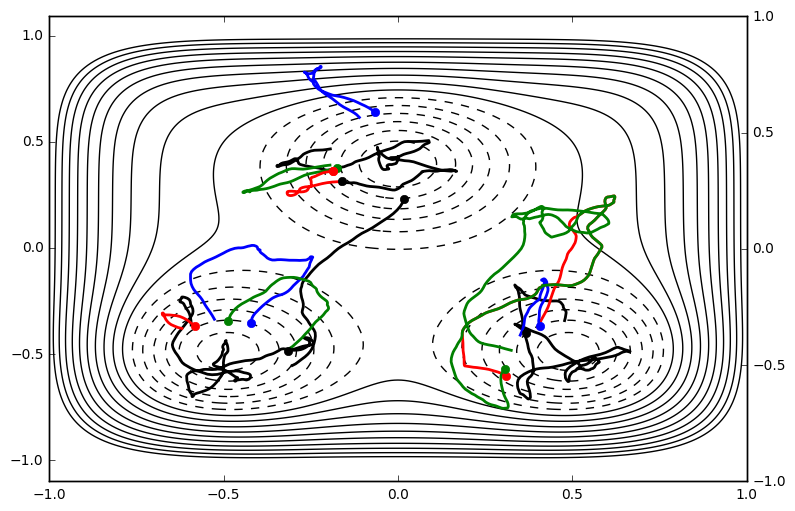

Working on Monte Carlo cycle number 146
Running for 25 seconds -  1.73 steps per second
Expected time to finish: 11511 seconds


In [ ]:
#! skip
# don't run all those steps in testing!
mstis_calc.run_until(n_steps)

In [37]:
storage.close()